In [6]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern, hog
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [7]:
# Function to apply Local Binary Patterns (LBP)
def apply_lbp(image, radius=1.0, n_points=8):
    lbp = local_binary_pattern(image, n_points, radius, method='ror')
    return lbp

def apply_hog(image):
    """Applies HOG (Histogram of Oriented Gradients) to an image and returns the features."""
    features = hog(image, orientations=9, pixels_per_cell=(8, 8), 
                              cells_per_block=(2, 2), block_norm='L2-Hys', 
                              transform_sqrt=True, visualize=False)
    return features

# Function to extract histograms as a feature
def extract_histogram(image):
    image_uint8 = np.uint8(image)
    hist = cv2.calcHist([image_uint8], [0], None, [256], [0, 256])
    return cv2.normalize(hist, hist).flatten()

def load_images(folder):
    """Loads images from a folder without extracting features, just stores the images and labels."""
    images = []
    labels = []
    classes = os.listdir(folder)  # Assuming subfolders are the labels (class names)
    
    for class_name in classes:
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    images.append(image)
                    labels.append(class_name)
    
    return images, np.array(labels)

def extract_features(images, feature_type='lbp'):
    """Applies the feature extraction type (HOG or LBP) to the loaded images."""
    X = []
    for image in images:
        if feature_type == 'lbp':
            lbp_image = apply_lbp(image)
            lbp_image = lbp_image[2:-2, 2:-2]
            features = extract_histogram(lbp_image)
        elif feature_type == 'hog':
            features = apply_hog(image)
        X.append(features)
    return np.array(X)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Function to display original image, convoluted image, and histogram
def show_image_convolution_histogram(image_path):
    # Load the original image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply convolution filter
    convoluted_image = apply_lbp(image)
    convoluted_image = convoluted_image[2:-2, 2:-2]
    features = extract_histogram(convoluted_image)
    
    # Extract histogram of the convoluted image
    hist = extract_histogram(convoluted_image)
    
    # Plot the images and histogram
    plt.figure(figsize=(15, 5))
    
    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    
    # Display convoluted image
    plt.subplot(1, 3, 2)
    plt.imshow(convoluted_image)
    plt.title('Convoluted Image')
    
    # Display histogram
    plt.subplot(1, 3, 3)
    plt.plot(hist)
    plt.title('Histogram')
    
    plt.tight_layout()
    plt.show()


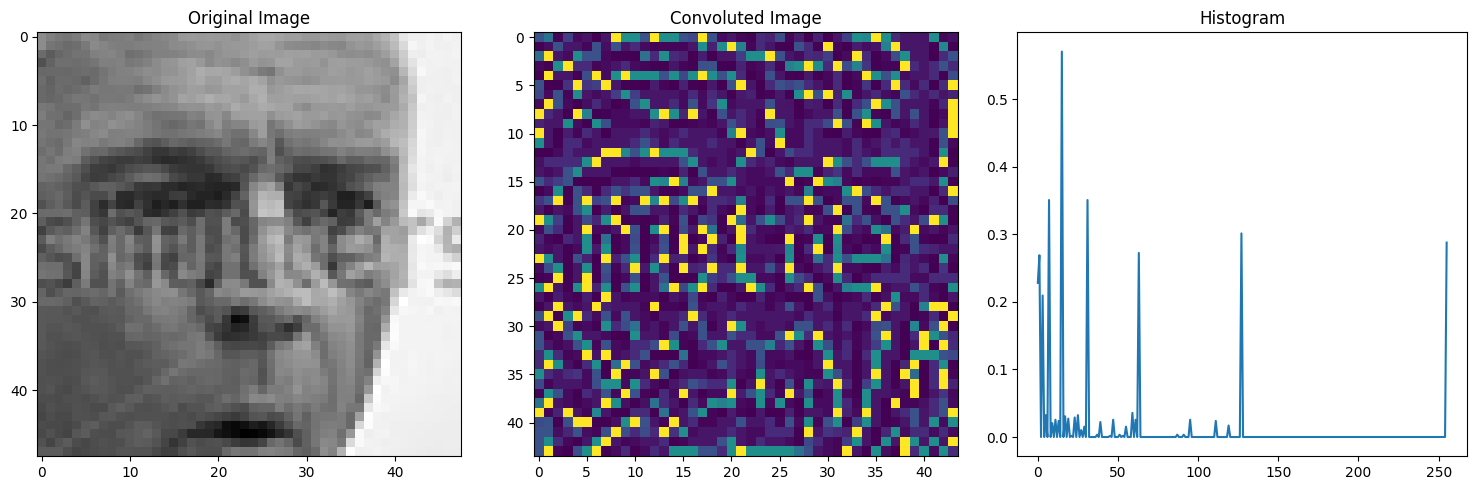

In [ ]:
# Paths for the train and test folders (replace with your root_path)
root_path = './dataset'
train_dir = os.path.join(root_path, 'train')
test_dir = os.path.join(root_path, 'test')

# Show an example of an original image, convoluted image, and histogram
example_image_path = os.path.join(train_dir, 'surprise', os.listdir(os.path.join(train_dir, 'surprise'))[0])
show_image_convolution_histogram(example_image_path)

# Step 1: Load the images (only once)
images_train, labels_train = load_images(train_dir)
images_test, labels_test = load_images(test_dir)

# Step 2: Extract features using LBP
X_lbp_train = extract_features(images_train, feature_type='lbp')
X_lbp_test = extract_features(images_test, feature_type='lbp')


## Results with LBP as feature function

Acurácia no teste: 0.27


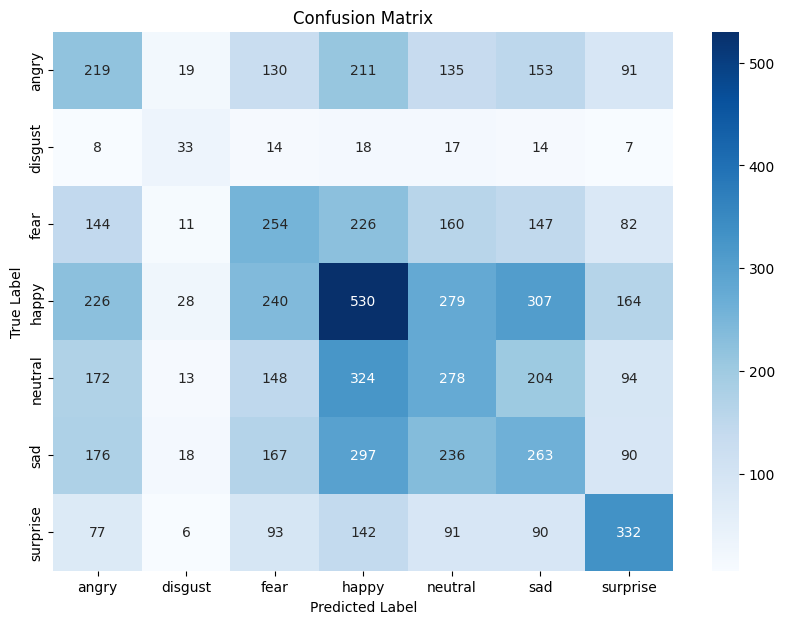

              precision    recall  f1-score   support

       angry       0.21      0.23      0.22       958
     disgust       0.26      0.30      0.28       111
        fear       0.24      0.25      0.25      1024
       happy       0.30      0.30      0.30      1774
     neutral       0.23      0.23      0.23      1233
         sad       0.22      0.21      0.22      1247
    surprise       0.39      0.40      0.39       831

    accuracy                           0.27      7178
   macro avg       0.27      0.27      0.27      7178
weighted avg       0.27      0.27      0.27      7178



In [4]:
# Train and evaluate the model using LBP
knn_lbp = KNeighborsClassifier(n_neighbors=1)
knn_lbp.fit(X_lbp_train, labels_train)

# Predict using the test data
y_lbp_pred_test = knn_lbp.predict(X_lbp_test)

# Evaluate the test accuracy
test_accuracy = accuracy_score(labels_test, y_lbp_pred_test)
print(f"Test accuracy: {test_accuracy:.2f}")

# Generate the confusion matrix
cm = confusion_matrix(labels_test, y_lbp_pred_test)

# Display the confusion matrix
plot_confusion_matrix(cm, np.unique(labels_test))

# Show the classification report
print(classification_report(labels_test, y_lbp_pred_test))


## Results with HOG as feature function

Acurácia no teste: 0.51


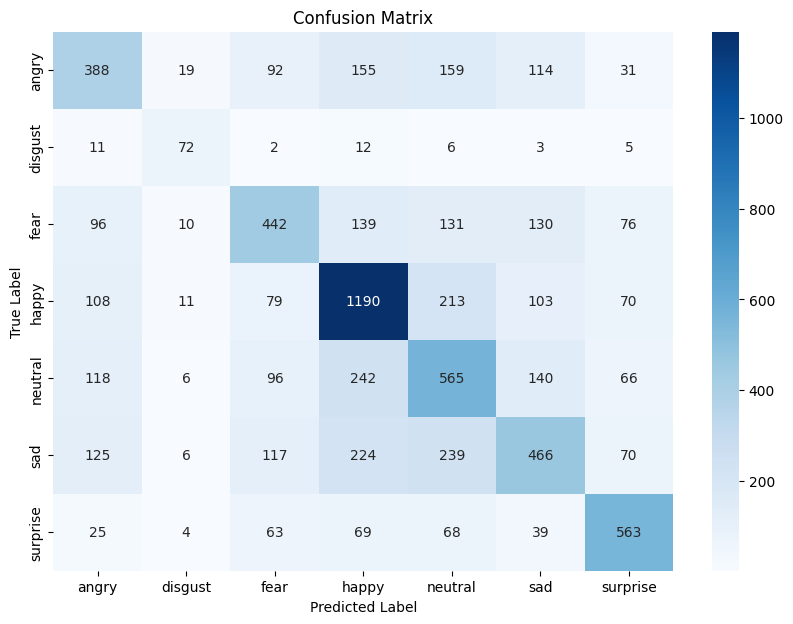

              precision    recall  f1-score   support

       angry       0.45      0.41      0.42       958
     disgust       0.56      0.65      0.60       111
        fear       0.50      0.43      0.46      1024
       happy       0.59      0.67      0.63      1774
     neutral       0.41      0.46      0.43      1233
         sad       0.47      0.37      0.42      1247
    surprise       0.64      0.68      0.66       831

    accuracy                           0.51      7178
   macro avg       0.52      0.52      0.52      7178
weighted avg       0.51      0.51      0.51      7178



In [5]:
# Extract features using HOG
X_hog_train = extract_features(images_train, feature_type='hog')
X_hog_test = extract_features(images_test, feature_type='hog')

# Train and evaluate the model using HOG
knn_hog = KNeighborsClassifier(n_neighbors=1)
knn_hog.fit(X_hog_train, labels_train)

# Predict using the test data
y_hog_pred_test = knn_hog.predict(X_hog_test)

# Evaluate the test accuracy
test_accuracy = accuracy_score(labels_test, y_hog_pred_test)
print(f"Test accuracy: {test_accuracy:.2f}")

# Generate the confusion matrix
cm = confusion_matrix(labels_test, y_hog_pred_test)

# Display the confusion matrix
plot_confusion_matrix(cm, np.unique(labels_train))

# Show the classification report
print(classification_report(labels_test, y_hog_pred_test))
